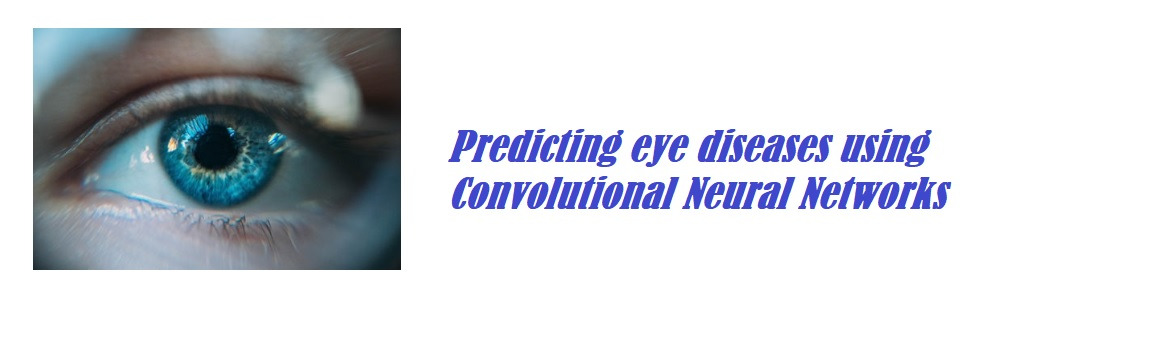

**Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from google.colab import drive
import os


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**Preprocessing**

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 50
CHANNELS = 3

The following code is uses TensorFlow's 'image_dataset_from_directory' method, which is a convenient way to load a dataset of images stored in a directory structure.

**Loads the dataset**: The method scans the directory at the specified path and assumes that the subdirectories represent class labels. For example, if there are subdirectories cat and dog, the method will assign the class 0 to all images in the cat folder and the class 1 to all images in the dog folder.

**Resizes images**: All images will be resized to the shape (IMAGE_SIZE, IMAGE_SIZE), ensuring a consistent input shape for the model.

**Shuffling**: The dataset will be shuffled to ensure randomness in the order of images during training.

**Batches**: The images will be loaded in batches of size BATCH_SIZE to facilitate efficient training on large datasets. The model will process the data in chunks rather than loading all the images into memory at once.

In [4]:
eye_disease_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4254 files belonging to 4 classes.


The code below retrieves the list of class names (labels) from the eye_disease_ds dataset object.

In [5]:
classifications = eye_disease_ds.class_names
classifications

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [6]:
for images, _ in eye_disease_ds.take(1):
    print(f"Image shape: {images[0].shape}")

Image shape: (256, 256, 3)


In [7]:
len(eye_disease_ds)

67

**Visualization**

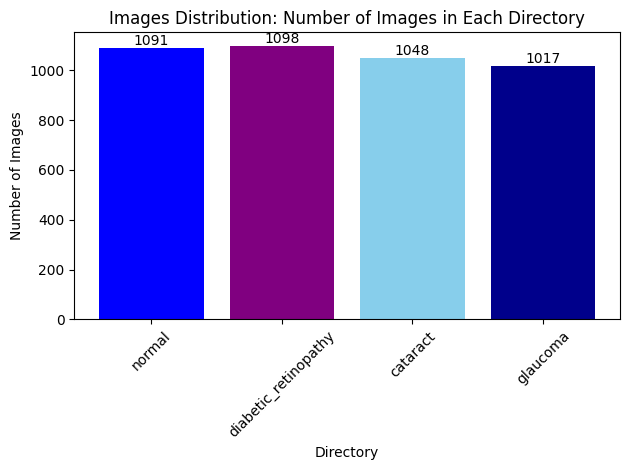

In [8]:
path = "/content/drive/My Drive/dataset"
# Count the number of images in each directory
subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

image_counts = [len(os.listdir(os.path.join(path, subfolder))) for subfolder in subfolders]
colors = ['blue', 'purple', 'skyblue', 'darkblue'][:len(subfolders)]
plt.bar(subfolders, image_counts, color=colors)

for i, count in enumerate(image_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Directory')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.title('Images Distribution: Number of Images in Each Directory')
plt.tight_layout()
plt.show()

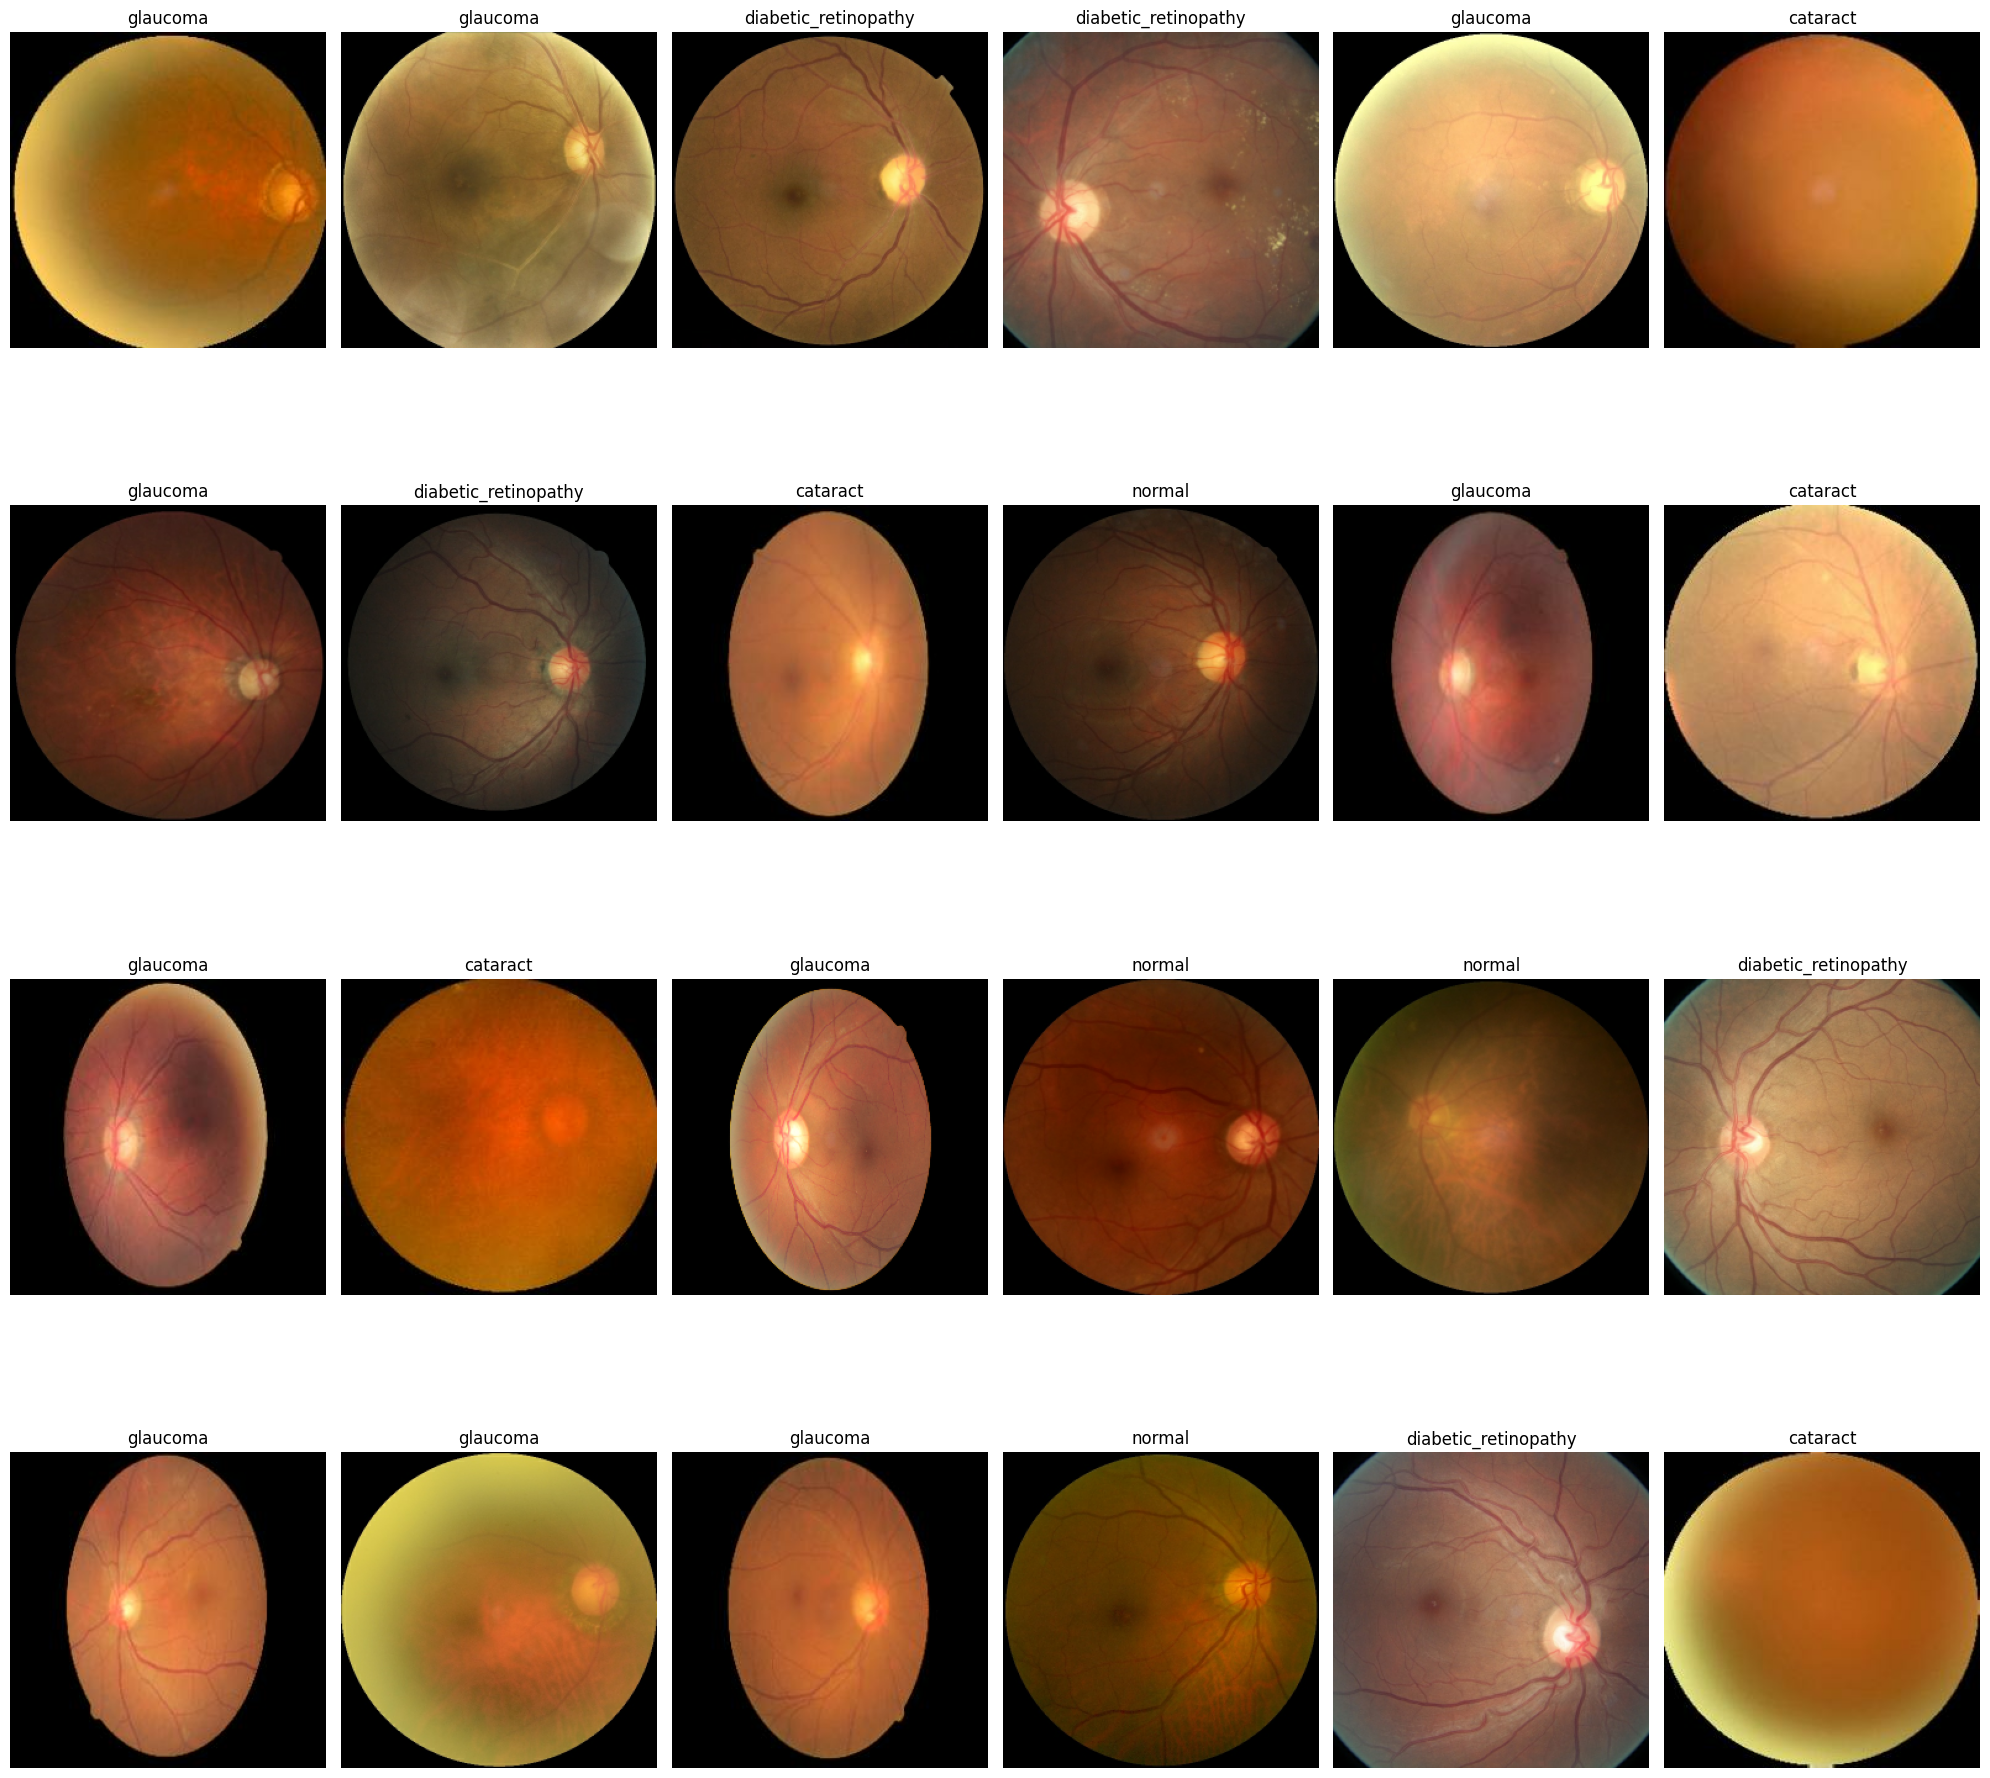

In [9]:
rows, cols = 4, 6

plt.figure(figsize=(20, rows * 5))
for image_batch, label_batch in eye_disease_ds.take(1):
    total_images = rows * cols
    for i in range(total_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classifications[label_batch[i]], fontsize=12)
        plt.axis("off")
plt.tight_layout()
plt.show()

**Criteria for Splitting the Dataset: 80% for training, 10% for validation,
10% for testing.**

In [10]:
def split_dataset_tf(dataset, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, shuffle=True, shuffle_buffer_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=12)
    train_size = int(train_ratio * dataset_size)
    validation_size = int(validation_ratio * dataset_size)
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    return train_dataset, validation_dataset, test_dataset

In [11]:
train_dataset, validation_dataset, test_dataset = split_dataset_tf(eye_disease_ds)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 53
Validation dataset size: 6
Test dataset size: 8


In [12]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image rescaling and resizing, along with data augmentation techniques**

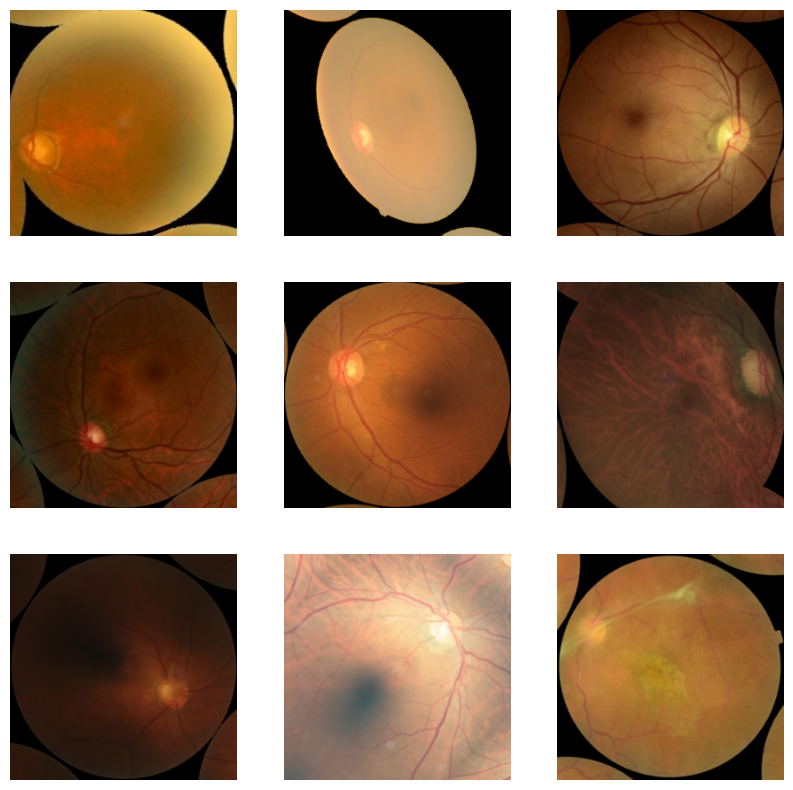

In [13]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

images_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

for images, _ in eye_disease_ds.take(1):
    augmented_images = images_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_cls = 4

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_rescale,
    images_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_cls, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=validation_dataset)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 792s 783ms/step - accuracy: 0.2958 - loss: 1.3700 - val_accuracy: 0.4557 - val_loss: 1.2374
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.4692 - loss: 1.1546 - val_accuracy: 0.5391 - val_loss: 1.0911
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5360 - loss: 0.9865 - val_accuracy: 0.5234 - val_loss: 1.0479
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6032 - loss: 0.8817 - val_accuracy: 0.5859 - val_loss: 0.9235
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6250 - loss: 0.8142 - val_accuracy: 0.6302 - val_loss: 0.8546
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.6532 - loss: 0.7755 - val_accuracy: 0.5938 - val_loss: 0.8614
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.6898 - loss: 0.7266 - val_accuracy: 0.6797 - val_loss: 0.7786
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7038 - loss: 0.6794 - val_accuracy: 

In [17]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

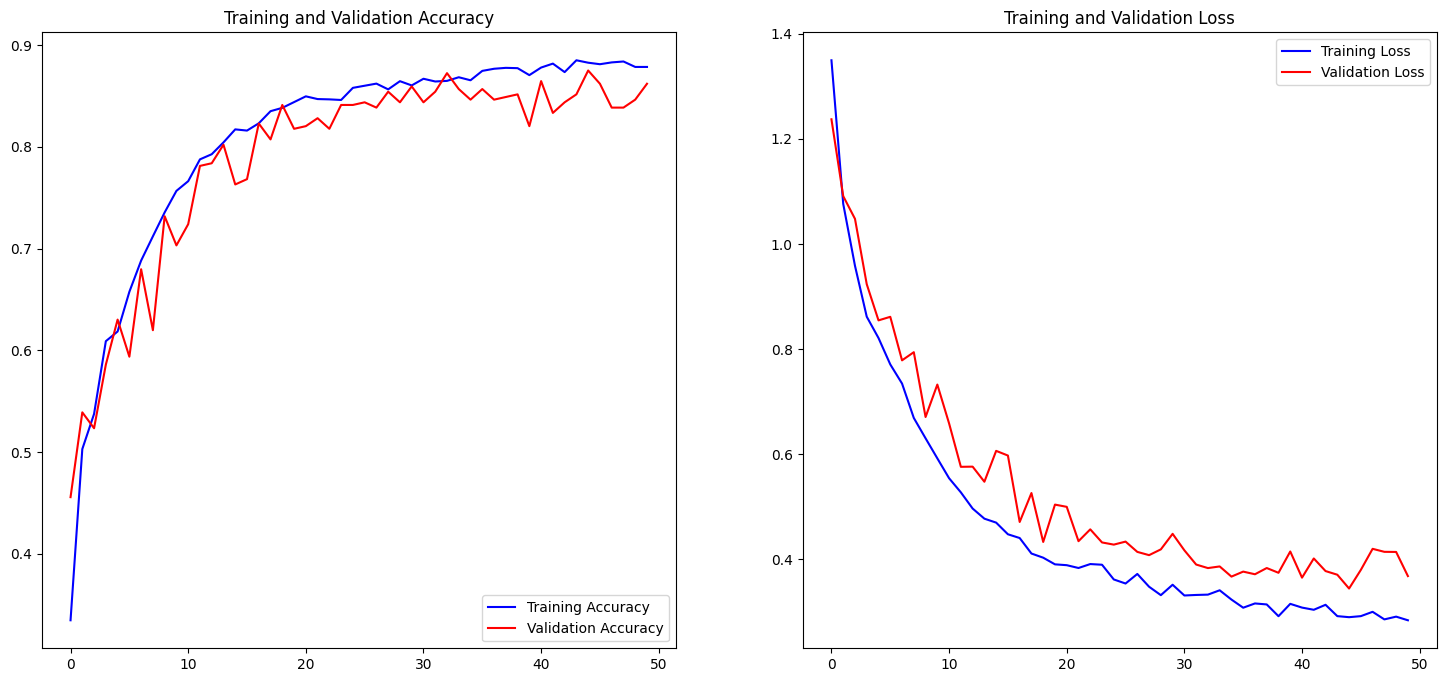

In [18]:
plt.figure(figsize=(18,8))
# Plot for Training and Validation Accuracy
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy', color='blue')
plt.plot(range(EPOCHS), validation_accuracy, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Plot for Training and Validation Loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='blue')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Predict**

Image's actual label: glaucoma
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step 
Predicted label: glaucoma
Image N1 to predict:


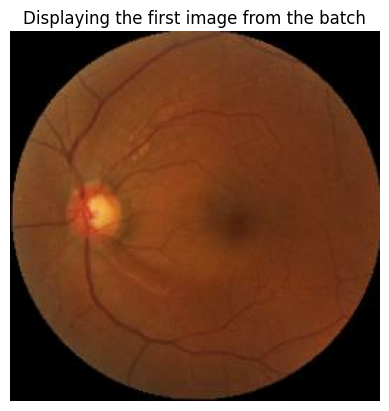

In [19]:
for images_batch, labels_batch in test_dataset.take(1):  # Take one batch from the dataset
    # Extracting the first image and its label from the batch
    image_1 = images_batch[0].numpy().astype('uint8')  # Convert to NumPy and cast to uint8
    label_1 = labels_batch[0].numpy()  # Get the true label of the first image

    print("Image's actual label:", classifications[label_1])
    # Predict the batch using the model
    batch_prediction = model.predict(images_batch)
    predicted_label_index = np.argmax(batch_prediction[0])  # Get the index of the highest probability
    predicted_label = classifications[predicted_label_index]  # Map the index to the class name
    print("Predicted label:", predicted_label)
    # Display the first image
    print("Image N1 to predict:")
    plt.imshow(image_1)
    plt.axis('off')
    plt.title("Displaying the first image from the batch")
    plt.show()



**Generating model predictions along with their accuracy.**

In [20]:
def predict_eye_disease(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = classifications[np.argmax(predictions[0])]
    accuracy = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


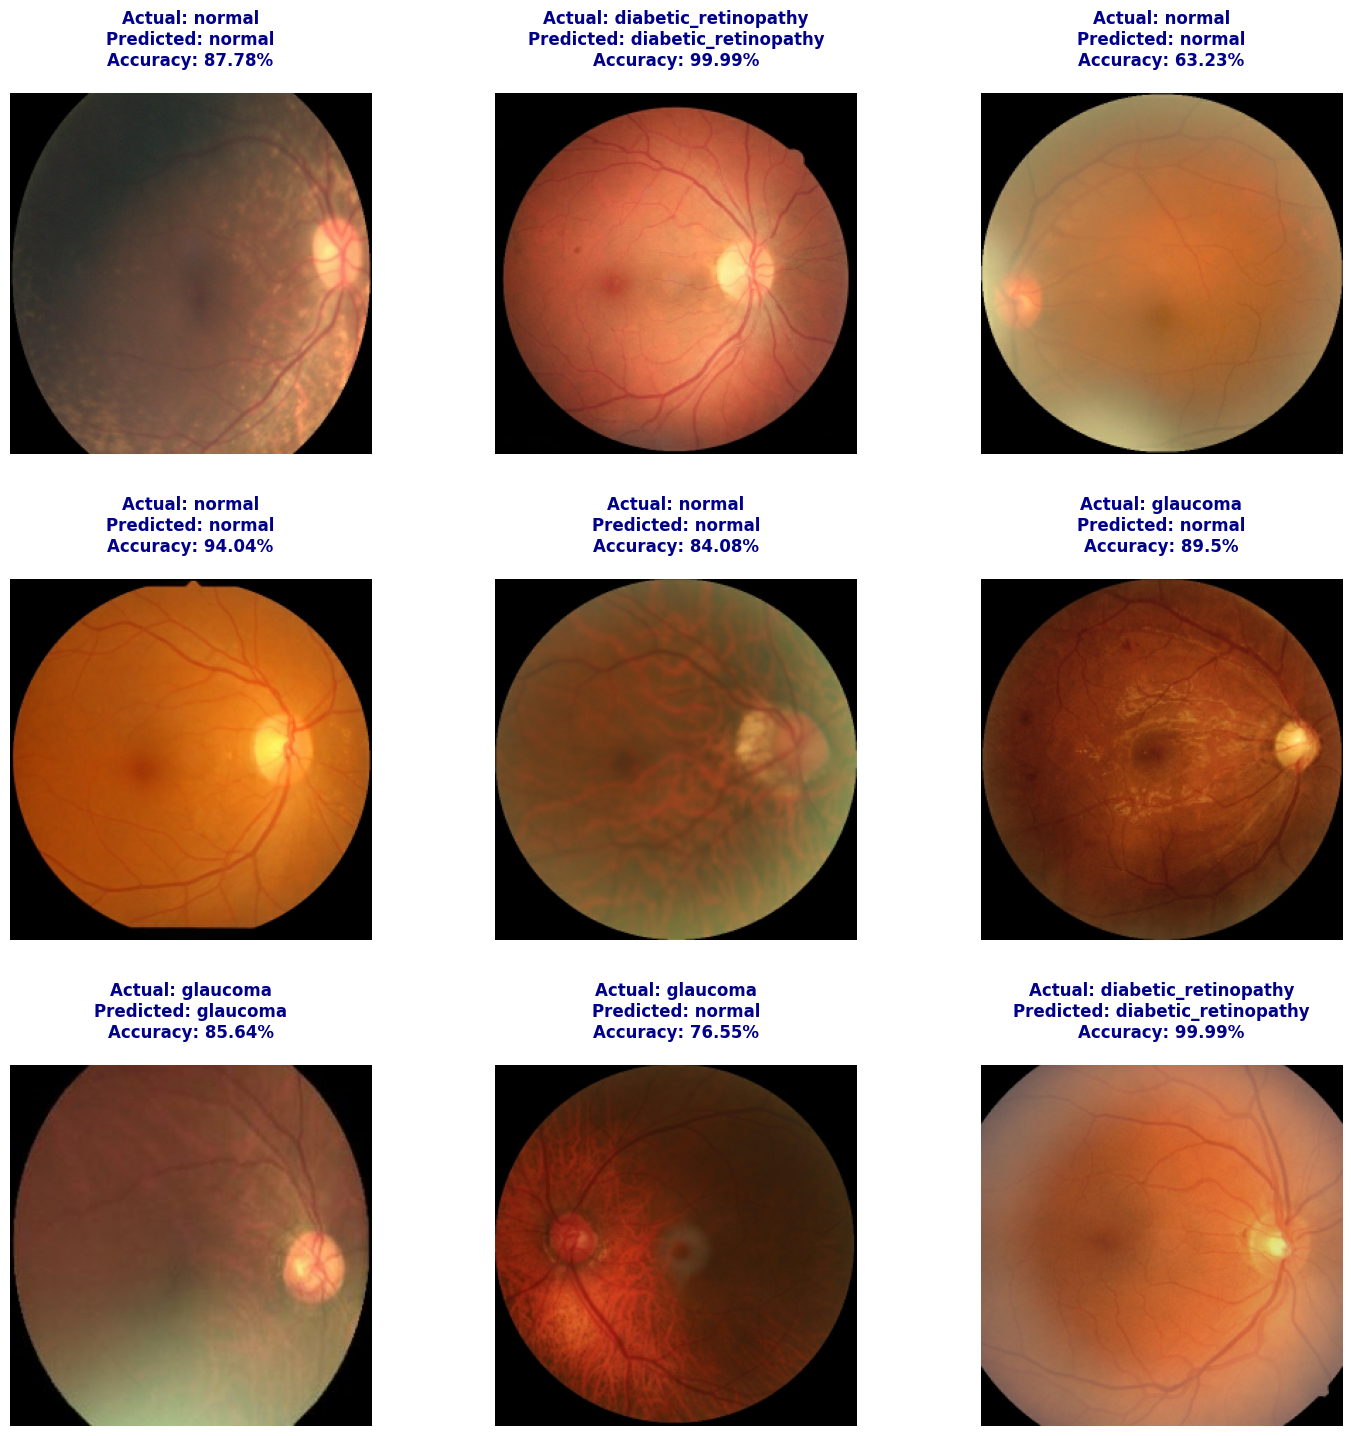

In [21]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        x = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, accuracy = predict_eye_disease(model, images[i].numpy())
        actual_class = classifications[labels[i]]
        title = f"Actual: {actual_class}\nPredicted: {predicted_class}\nAccuracy: {accuracy}%"
        plt.title(title, fontsize=12, pad=20, weight='bold', color='darkblue')
        plt.axis("off")
        x.set_facecolor('lightgray')
        x.grid(False)

plt.tight_layout(pad=3.0)
plt.show()

**Real-time prediction**

In [22]:
!pip install ipywidgets
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00


FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


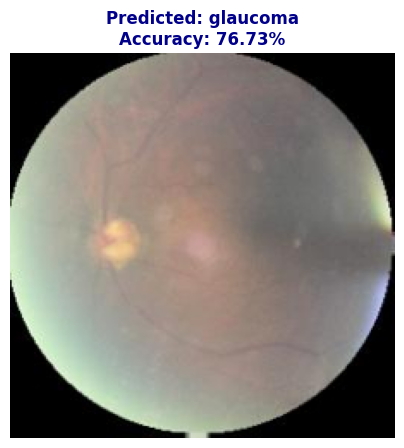

In [72]:
import cv2
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

def predict_eye_disease_uploaded(model, img):
    # Convert image to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Expand dimensions to create a batch
    img_array = tf.expand_dims(img_array, axis=0)

    # Get predictions
    predictions = model.predict(img_array)
    predicted_class = classifications[np.argmax(predictions[0])]
    accuracy = round(100 * np.max(predictions[0]), 2)
    return predicted_class, accuracy

def on_upload_change(change):
    uploaded_files = change['new']

    if uploaded_files:
        # Get first file (Only one file is expected)
        file_name = list(uploaded_files.keys())[0]  # Extract filename
        content = uploaded_files[file_name]['content']  # Extract file content

        img = Image.open(io.BytesIO(content)).convert('RGB')

        # Resize to match model's expected input
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

        # Predict
        predicted_class, accuracy = predict_eye_disease_uploaded(model, img)

        # Display image
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}\nAccuracy: {accuracy}%", fontsize=12, weight='bold', color='darkblue')
        plt.axis('off')
        plt.show()

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(on_upload_change, names='value')
display(upload_button)
